学习R语言断点回归。

In [5]:
library(rdrobust)
library(tidyverse)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.5
v forcats   1.0.0     v stringr   1.5.1
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.4     v tidyr     1.3.1
v purrr     1.0.2     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


# SRD

In [ ]:
data(rdrobust_RDsenate)
head(rdrobust_RDsenate)
# vote：表示某次选举民主党在州参议院的席位占比，值从0到100，是RD分析中结局变量
# margin：表示上次选举中获得相同参议院席位的边际收益，其中大于0表示民主党胜出，反之则为失败。
# 利用RDD估计民主党赢得参议院席位对其在下次选举中获得该席位的选票份额的影响

,margin,vote
,<dbl>,<dbl>
1,-7.6885610,36.09757
2,-3.9237082,45.46875
3,-6.8686604,45.59821
4,-27.6680565,48.47606
5,-8.2569685,51.74687
6,0.7324815,39.80264


## 内部有效性(Internal Validity)条件的检验

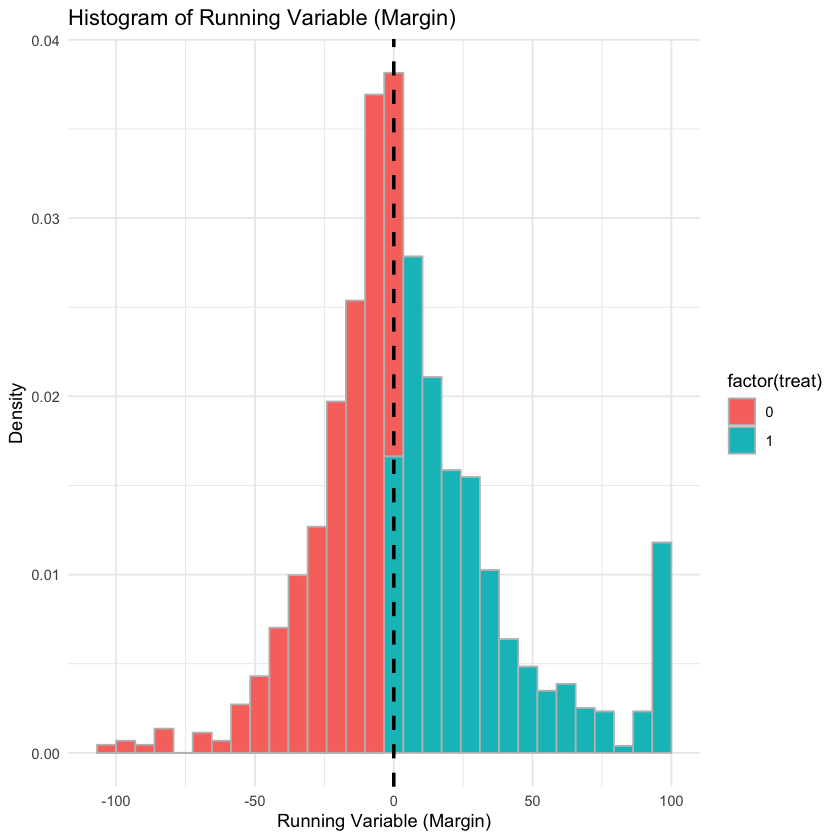

In [29]:
library(rdrobust)
library(magrittr)
data(rdrobust_RDsenate)

data_RDD <- rdrobust_RDsenate %>%
  mutate(treat = ifelse(margin > 0, 1, 0))

# 绘制直方图
data_RDD %>%
  ggplot(aes(x = margin, fill = factor(treat))) +
  geom_histogram(
    aes(y = ..density..),
    color = "grey",
    bins = 30
  ) +
  geom_vline(
    xintercept = 0,
    linetype = "dashed",
    color = "black",
    size = 1
  ) +
  labs(
    title = "Histogram of Running Variable (Margin)",
    x = "Running Variable (Margin)",
    y = "Density"
  ) +
  theme_minimal()

In [32]:
library(rddensity)

        Length Class     Mode
Estl     4     lpdensity list
Estr     4     lpdensity list
Estplot 11     gg        list

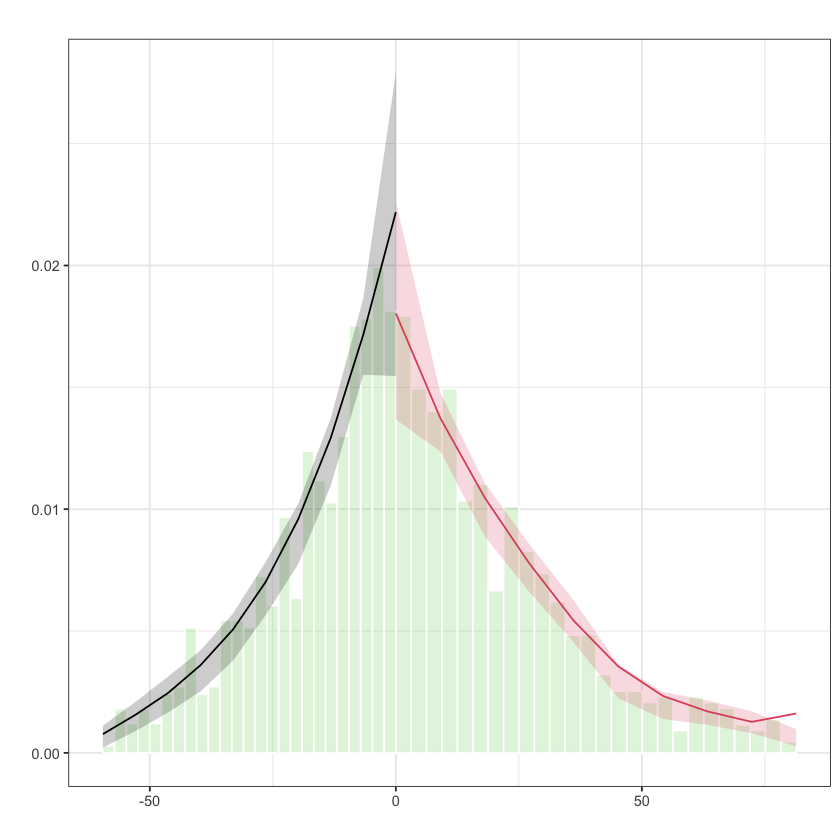

In [ ]:
# 方法二
# 使用rdplotdensity函数绘制密度图
summary(rdplotdensity(rddensity(rdrobust_RDsenate$margin), X = rdrobust_RDsenate$margin))

        Length Class     Mode
Estl     4     lpdensity list
Estr     4     lpdensity list
Estplot 11     gg        list

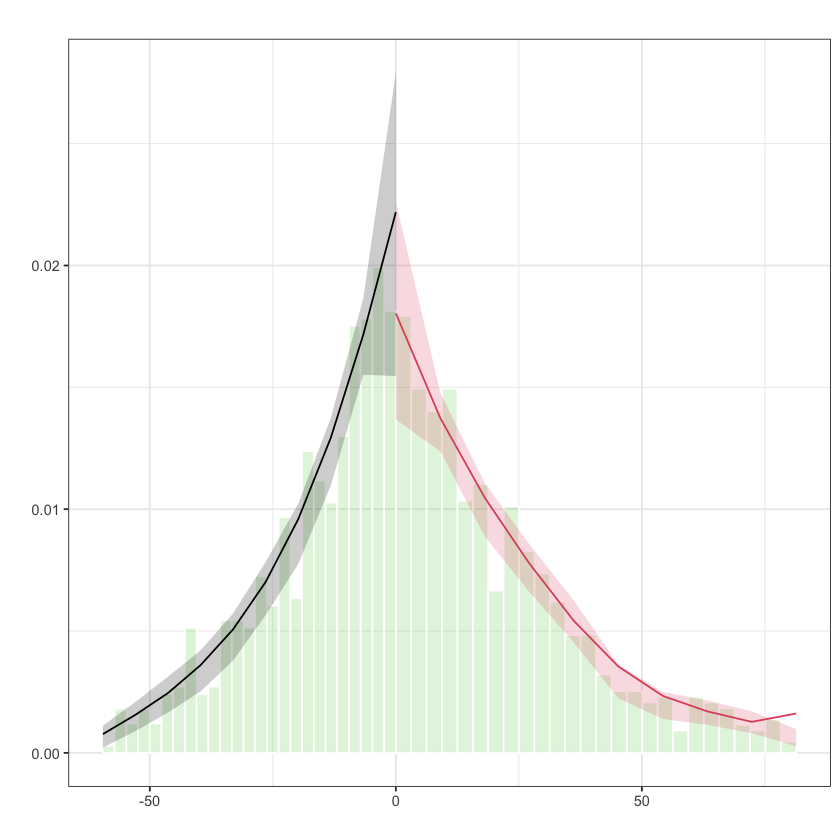

In [37]:
# 第三步：绘制密度图
summary(rdplotdensity(density_test, X = rdrobust_RDsenate$margin))

In [ ]:
# McCrary 检验
# 假设 margin 是你的断点变量
density_test <- rddensity(X = data_RDD$margin)

# 查看检验结果
summary(density_test)


Manipulation testing using local polynomial density estimation.

Number of obs =       1390
Model =               unrestricted
Kernel =              triangular
BW method =           estimated
VCE method =          jackknife

c = 0                 Left of c           Right of c          
Number of obs         640                 750                 
Eff. Number of obs    408                 460                 
Order est. (p)        2                   2                   
Order bias (q)        3                   3                   
BW est. (h)           19.841              27.119              

Method                T                   P > |T|             
Robust                -0.8753             0.3814              



Warning message in summary.CJMrddensity(density_test):
"There are repeated observations. Point estimates and standard errors have been adjusted. Use option massPoints=FALSE to suppress this feature."



P-values of binomial tests (H0: p=0.5).

Window Length / 2          <c     >=c    P>|T|
1.080                      20      31    0.1608
2.160                      51      55    0.7709
3.240                      88      79    0.5360
4.320                     116     107    0.5923
5.400                     140     131    0.6271
6.480                     159     151    0.6910
7.560                     193     171    0.2710
8.640                     225     191    0.1056
9.720                     245     215    0.1763
10.800                    263     241    0.3496


## 驱动变量与干预措施之间的关系图

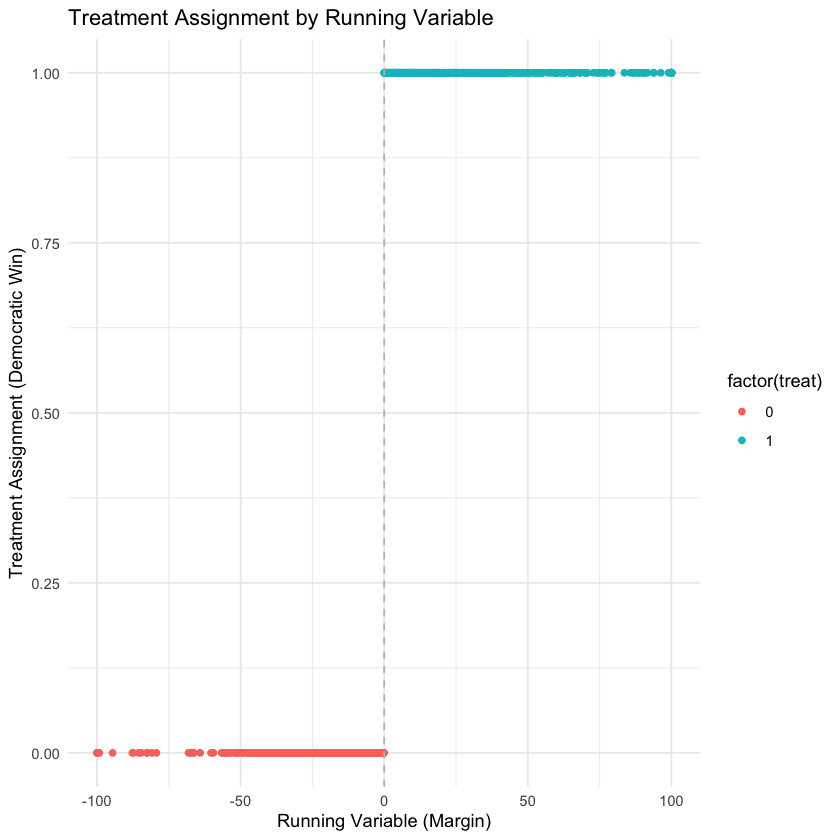

In [40]:
# 绘制驱动变量与干预措施之间的关系图
ggplot(data_RDD, aes(x = margin, y = treat, color = factor(treat))) +
  geom_point() +
  geom_vline(xintercept = 0, linetype = "dashed", color = "grey") +
  labs(title = "Treatment Assignment by Running Variable",
       x = "Running Variable (Margin)",
       y = "Treatment Assignment (Democratic Win)") +
  theme_minimal()

Warning message:
"Removed 93 rows containing missing values or values outside the scale range
(`geom_point()`)."


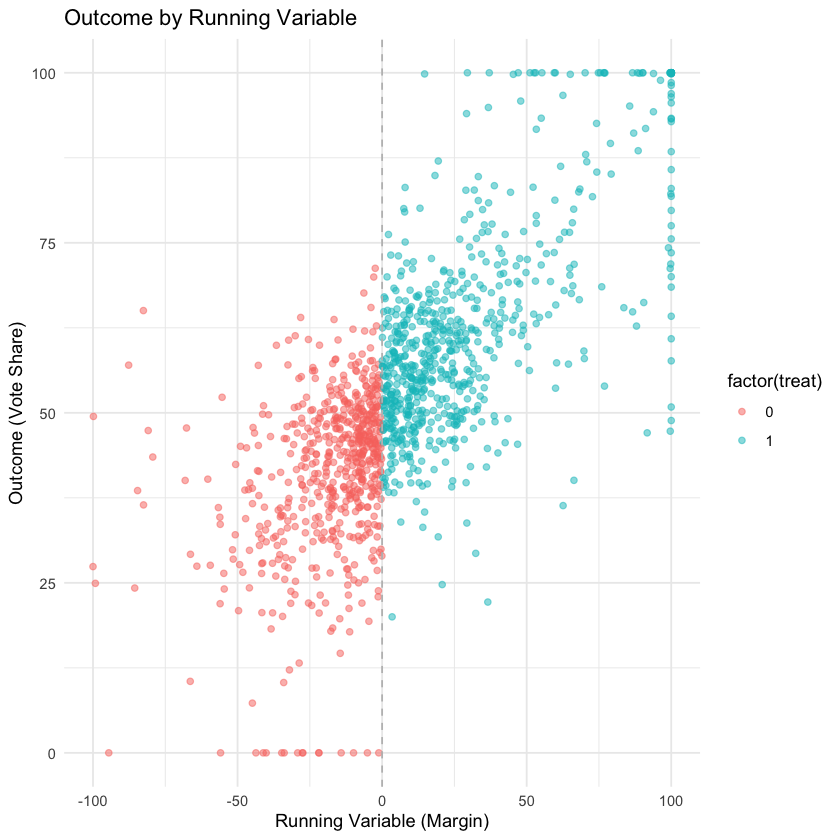

In [41]:
# 画驱动变量与结果变量的关系图
# 散点图初步判定关系
ggplot(data_RDD, aes(x = margin, y = vote)) +
  geom_point(aes(color = factor(treat)), alpha = 0.5) +
  geom_vline(xintercept = 0, linetype = "dashed", color = "grey") +
  labs(title = "Outcome by Running Variable",
       x = "Running Variable (Margin)",
       y = "Outcome (Vote Share)") +
  theme_minimal()

## 画驱动变量与结果变量的关系图，选择合适的bin数量

Call: rdplot

Number of Obs.                 1297
Kernel                      Uniform

Number of Obs.                  595             702
Eff. Number of Obs.             595             702
Order poly. fit (p)               4               4
BW poly. fit (h)            100.000         100.000
Number of bins scale              1               1

Bins Selected                    20              20
Average Bin Length            5.000           5.000
Median Bin Length             5.000           5.000

IMSE-optimal bins                 8               9
Mimicking Variance bins          15              35

Relative to IMSE-optimal:
Implied scale                 2.500           2.222
WIMSE variance weight         0.060           0.084
WIMSE bias weight             0.940           0.916



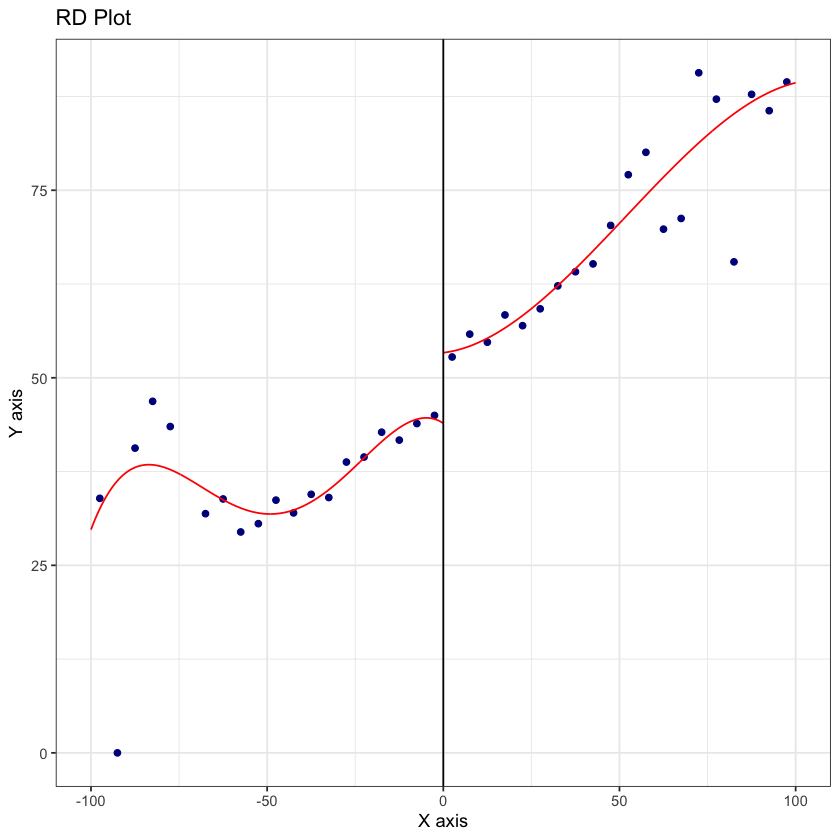

In [42]:
bins <- rdplot(
  data_RDD$vote,
  data_RDD$margin,
  c = 0,
  p = 4,
  nbins = c(20, 20),
  binselect = 'esmv',
  kernel = 'uniform'
)

summary(bins)

## 模型估计效应大小

### 全局参数估计

In [62]:
# 数据处理
data_RDD <- data_RDD %>% mutate(margin_del = margin - 0) # 处理断点变量

# linear
fit_1 <- lm(
  vote ~ margin_del + treat,
  data = data_RDD
)

# linear interaction
fit_2 <- lm(
  vote ~ margin_del * treat,
  data = data_RDD
)

# quadratic
fit_3 <- lm(
  vote ~ margin_del + I(margin_del ^ 2) + treat,
  data = data_RDD
)

# quadratic interaction
fit_4 <- lm(
  vote ~ (margin_del + I(margin_del ^ 2)) * treat,
  data = data_RDD
)

# cubic
fit_5 <- lm(
  vote ~ margin_del + I(margin_del ^ 2) + I(margin_del ^ 3) + treat,
  data = data_RDD
)

# cubic interaction
fit_6 <- lm(
  vote ~ (margin_del + I(margin_del ^ 2) + I(margin_del ^ 3)) * treat,
  data = data_RDD
)

# 整合结果
library(stargazer)

stargazer(
  fit_1, fit_2, fit_3, fit_4, fit_5, fit_6,
  title = "Regression Results",
  type = "html",
  out = "regression_results.html"
)


<table style="text-align:center"><caption><strong>Regression Results</strong></caption>
<tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="6"><em>Dependent variable:</em></td></tr>
<tr><td></td><td colspan="6" style="border-bottom: 1px solid black"></td></tr>
<tr><td style="text-align:left"></td><td colspan="6">vote</td></tr>
<tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td><td>(3)</td><td>(4)</td><td>(5)</td><td>(6)</td></tr>
<tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">margin_del</td><td>0.348<sup>***</sup></td><td>0.216<sup>***</sup></td><td>0.285<sup>***</sup></td><td>0.421<sup>***</sup></td><td>0.337<sup>***</sup></td><td>0.285<sup>*</sup></td></tr>
<tr><td style="text-align:left"></td><td>(0.013)</td><td>(0.028)</td><td>(0.017)</td><td>(0.069)</td><td>(0.028)</td><td>(0.151)</td></tr>
<tr><td style="text-align:left"></td><td></td><td></td><td></

In [63]:
AIC(fit_1, fit_2, fit_3, fit_4, fit_5, fit_6)

,df,AIC
,<dbl>,<dbl>
fit_1,4,10083.70
fit_2,5,10056.71
fit_3,5,10049.89
fit_4,7,10048.72
fit_5,6,10046.19
fit_6,9,10045.74


###  局部非参数估计

In [65]:
rdbwselect(
  y = data_RDD$vote,
  x = data_RDD$margin,
  all = TRUE
) %>%
  summary()

Call: rdbwselect

Number of Obs.                 1297
BW type                         All
Kernel                   Triangular
VCE method                       NN

Number of Obs.                  595          702
Order est. (p)                    1            1
Order bias  (q)                   2            2
Unique Obs.                     595          665

                  BW est. (h)    BW bias (b)
            Left of c Right of c  Left of c Right of c
     mserd    17.754     17.754     28.028     28.028
    msetwo    16.170     18.126     27.104     29.344
    msesum    18.365     18.365     31.319     31.319
  msecomb1    17.754     17.754     28.028     28.028
  msecomb2    17.754     18.126     28.028     29.344
     cerrd    12.407     12.407     28.028     28.028
    certwo    11.299     12.667     27.104     29.344
    cersum    12.834     12.834     31.319     31.319
  cercomb1    12.407     12.407     28.028     28.028
  cercomb2    12.407     12.667     28.028     29.344


In [ ]:
loc_fit_1 <- rdrobust(
  data_RDD$vote,
  data_RDD$margin,
  c = 0, p = 1,
  kernel = 'triangular',
  bwselect = 'msetwo'
) # 如果有混杂因素需要控制,可以用covs = c('var1', 'var2')

loc_fit_2 <- rdrobust(
  data_RDD$vote,
  data_RDD$margin,
  c = 0, p = 2,
  kernel = 'triangular',
  bwselect = 'msetwo'
) # c用来指定cut-point，p用来指定局部加权回归的多项式幂次

loc_fit_3 <- rdrobust(
  data_RDD$vote,
  data_RDD$margin,
  c = 0, p = 1,
  kernel = 'triangular',
  bwselect = 'cerrd'
)

loc_fit_4 <- rdrobust(
  data_RDD$vote,
  data_RDD$margin,
  c = 0, p = 2,
  kernel = 'triangular',
  bwselect = 'cerrd'
)

summary(loc_fit_1)

Sharp RD estimates using local polynomial regression.

Number of Obs.                 1297
BW type                      msetwo
Kernel                   Triangular
VCE method                       NN

Number of Obs.                  595          702
Eff. Number of Obs.             336          326
Order est. (p)                    1            1
Order bias  (q)                   2            2
BW est. (h)                  16.170       18.126
BW bias (b)                  27.104       29.344
rho (h/b)                     0.597        0.618
Unique Obs.                     595          665

        Method     Coef. Std. Err.         z     P>|z|      [ 95% C.I. ]       
  Conventional     7.454     1.497     4.979     0.000     [4.519 , 10.388]    
        Robust         -         -     4.282     0.000     [4.085 , 10.982]    


## 敏感性分析

In [69]:
sen_cut_1 <- rdrobust(
  data_RDD$vote,
  data_RDD$margin,
  c = 1,
  p = 1,
  kernel = 'triangular',
  bwselect = 'msetwo'
)

sen_cut_2 <- rdrobust(
  data_RDD$vote,
  data_RDD$margin,
  c = -1,
  p = 1,
  kernel = 'triangular',
  bwselect = 'msetwo'
)

summary(sen_cut_1)
summary(sen_cut_2)

Sharp RD estimates using local polynomial regression.

Number of Obs.                 1297
BW type                      msetwo
Kernel                   Triangular
VCE method                       NN

Number of Obs.                  620          677
Eff. Number of Obs.             370          346
Order est. (p)                    1            1
Order bias  (q)                   2            2
BW est. (h)                  17.852       21.433
BW bias (b)                  32.135       35.101
rho (h/b)                     0.556        0.611
Unique Obs.                     620          640

        Method     Coef. Std. Err.         z     P>|z|      [ 95% C.I. ]       
  Conventional     5.267     1.406     3.747     0.000     [2.512 , 8.022]     
        Robust         -         -     3.024     0.002     [1.746 , 8.176]     
Sharp RD estimates using local polynomial regression.

Number of Obs.                 1297
BW type                      msetwo
Kernel                   Triangular
VCE 

In [70]:
data_RDD_hole_1 <- data_RDD %>% filter(margin > 0.3)
data_RDD_hole_2 <- data_RDD %>% filter(margin > 0.4)
data_RDD_hole_3 <- data_RDD %>% filter(margin > 0.5)

sen_hole_1 <- rdrobust(
  data_RDD_hole_1$vote,
  data_RDD_hole_1$margin,
  c = 1,
  p = 1,
  kernel = 'triangular',
  bwselect = 'msetwo'
)

sen_hole_2 <- rdrobust(
  data_RDD_hole_2$vote,
  data_RDD_hole_2$margin,
  c = 1,
  p = 1,
  kernel = 'triangular',
  bwselect = 'msetwo'
)

sen_hole_3 <- rdrobust(
  data_RDD_hole_3$vote,
  data_RDD_hole_3$margin,
  c = 1,
  p = 1,
  kernel = 'triangular',
  bwselect = 'msetwo'
)

summary(sen_hole_1)
summary(sen_hole_2)
summary(sen_hole_3)

Sharp RD estimates using local polynomial regression.

Number of Obs.                  696
BW type                      msetwo
Kernel                   Triangular
VCE method                       NN

Number of Obs.                   19          677
Eff. Number of Obs.              18          346
Order est. (p)                    1            1
Order bias  (q)                   2            2
BW est. (h)                   0.663       21.424
BW bias (b)                   0.663       34.917
rho (h/b)                     1.000        0.614
Unique Obs.                      19          640

        Method     Coef. Std. Err.         z     P>|z|      [ 95% C.I. ]       
  Conventional     0.673     3.647     0.184     0.854    [-6.475 , 7.820]     
        Robust         -         -     0.800     0.424    [-5.461 , 12.986]    
Sharp RD estimates using local polynomial regression.

Number of Obs.                  692
BW type                      msetwo
Kernel                   Triangular
VCE 

# FRD

In [ ]:
set.seed(2025)
n <- 1000

# 断点变量（running variable）
x <- runif(n, -1, 1)

# 模糊处理变量：断点右侧更可能接受处理
prob_d <- ifelse(x >= 0, 0.7, 0.3)
d <- rbinom(n, 1, prob_d)

# 协变量
z1 <- rnorm(n, mean = 30, sd = 5)         # 年龄
z2 <- rbinom(n, 1, 0.5)                   # 性别（0=女，1=男）
z3 <- rpois(n, lambda = 12)               # 教育年限

# 结果变量：受处理、断点变量、协变量影响
y <- 2 * d + 0.5 * x + 0.1 * z1 - 0.3 * z2 + 0.2 * z3 + rnorm(n)

# 整合为数据框
data_fuzzy <- data.frame(x = x, d = d, y = y, z1 = z1, z2 = z2, z3 = z3)

# 查看前几行
head(data_fuzzy)

,x,d,y,z1,z2,z3
,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>
1,0.465240310,1,7.529305,34.36990,1,11
2,-0.048477135,0,5.131856,19.61666,1,14
3,0.028431709,0,2.992636,26.96008,1,8
4,-0.003135487,1,4.798242,22.89001,1,10
5,0.560569047,1,10.233660,26.33068,0,13
6,0.008504318,1,7.798885,26.42092,0,16


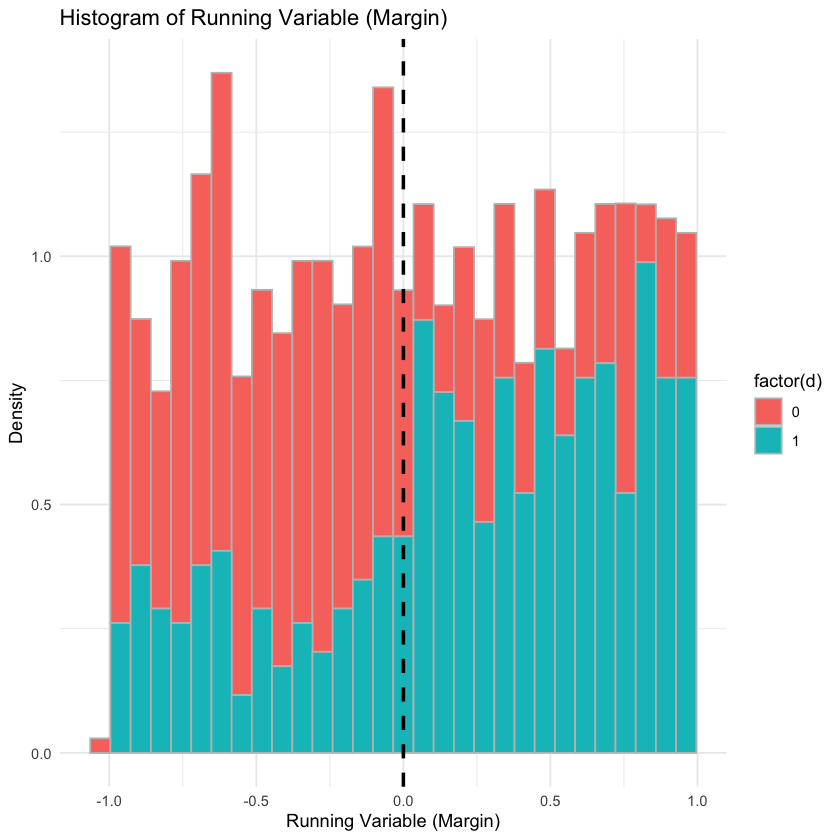

In [74]:
library(rdrobust)
library(magrittr)
data(rdrobust_RDsenate)

# 绘制直方图
data_fuzzy %>%
  ggplot(aes(x = x, fill = factor(d))) +
  geom_histogram(
    aes(y = ..density..),
    color = "grey",
    bins = 30
  ) +
  geom_vline(
    xintercept = 0,
    linetype = "dashed",
    color = "black",
    size = 1
  ) +
  labs(
    title = "Histogram of Running Variable (Margin)",
    x = "Running Variable (Margin)",
    y = "Density"
  ) +
  theme_minimal()